Plot zonal mean biases. This notebook depends on model output generated by the `train-evaluate-prognostic-run` workflow. Note that the notebook makes a somewhat expensive calculation and so will take ~20min to run.

Generates Figure S6.

In [1]:
import xarray as xr
import fsspec
import numpy as np
import dask
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import vcm
plt.rcParams['figure.dpi'] = 150
xr.set_options(keep_attrs=True)

In [2]:
client = dask.distributed.Client()

In [3]:
urls = {
    'rf-control': 'gs://vcm-ml-experiments/2021-03-15-nudge-to-obs-GRL-paper-rev1/rf-control/prognostic_run/atmos_4xdaily.zarr',
    'rf-dQ1-dQ2-only': 'gs://vcm-ml-experiments/2021-03-15-nudge-to-obs-GRL-paper-rev1/rf-dQ1-dQ2-only/prognostic_run/atmos_4xdaily.zarr',
    'baseline': 'gs://vcm-ml-experiments/2020-10-30-nudge-to-obs-GRL-paper/baseline-run-2016/atmos_4xdaily.zarr',
}
plot_titles = {
    'rf-control': 'ML-corrected',
    'rf-dQ1-dQ2-only': 'ML-corrected ($\Delta Q_1$, $\Delta Q_2$ only)',
    'baseline': 'baseline',
}
verification_url = 'gs://vcm-ml-experiments/2020-10-30-nudge-to-obs-GRL-paper/nudge-to-obs-run-3hr-diags/after_physics.zarr'
nudging_tendencies_url = 'gs://vcm-ml-experiments/2020-10-30-nudge-to-obs-GRL-paper/nudge-to-obs-run-3hr-diags/nudging_tendencies.zarr'
variables = ['sphum', 'ucomp', 'vcomp', 'temp']
nudging_variables = ['t_dt_nudge', 'q_dt_nudge', 'u_dt_nudge', 'v_dt_nudge']

In [4]:
def open_zarr(url):
    m = fsspec.get_mapper(url)
    return xr.open_zarr(m, consolidated=True)

def zonal_mean(
    ds: xr.Dataset, latitude: xr.DataArray, bins=np.arange(-90, 91, 2)
) -> xr.Dataset:
    zm = ds.groupby_bins(latitude, bins=bins).mean().rename(lat_bins="latitude")
    latitude_midpoints = [x.item().mid for x in zm["latitude"]]
    return zm.assign_coords(latitude=latitude_midpoints)

Open data

In [5]:
prognostic = []
for run, url in urls.items():
    prognostic.append(open_zarr(url).set_coords(['lat', 'latb', 'lon', 'lonb']).assign_coords(run=plot_titles[run]))
prognostic = xr.concat(prognostic, dim='run')

In [6]:
verification = open_zarr(verification_url)
verification = verification.rename(
    air_temperature='temp', eastward_wind='ucomp', northward_wind='vcomp', specific_humidity='sphum', 
    pressure_thickness_of_atmospheric_layer='delp', x='grid_xt', y='grid_yt', z='pfull'
)

In [7]:
prognostic = prognostic[variables + ['delp']]
verification = verification[variables + ['delp']]

In [8]:
ds = xr.concat([prognostic, verification.assign_coords(run='verif')], dim='run', join='inner')
ds['sphum'] = 1000 * ds['sphum'].assign_attrs(units='g/kg')

Interpolate to pressure

In [9]:
ds_on_pressure = vcm.interpolate_to_pressure_levels(ds[variables], ds.delp)
for variable in ds_on_pressure:
    ds_on_pressure[variable] = ds_on_pressure[variable].assign_attrs(ds[variable].attrs)
ds_on_pressure = ds_on_pressure.assign_coords(pressure=ds_on_pressure.pressure / 100)
ds_on_pressure['pressure'] = ds_on_pressure.pressure.assign_attrs(units='hPa')

Zonal and time mean

In [10]:
ds_zm_clim = zonal_mean(ds_on_pressure, ds_on_pressure.lat).mean('time')

Force compute (~20 minutes)

In [11]:
for varname in ds_zm_clim.data_vars:
    ds_zm_clim[varname] = ds_zm_clim[varname].compute()

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [12]:
bias = ds_zm_clim - ds_zm_clim.sel(run='verif')
for variable in bias:
    bias[variable] = bias[variable].assign_attrs(long_name=f"{bias[variable].long_name} bias")

### Plot zonal mean temperature, specific humidity, zonal wind and meridional wind
First plot climatologies (average over 2016) then plot bias relative to verif (which is the nudged run, so not the "true" verification dataset, which would be the GFS analysis).

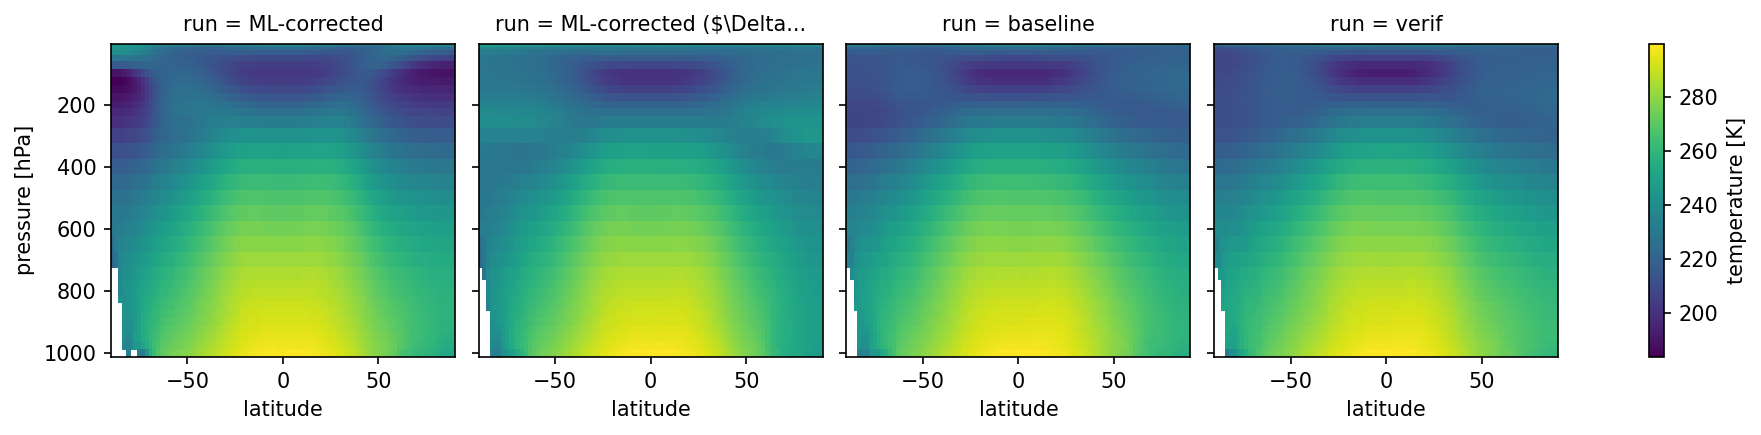

In [13]:
ds_zm_clim.temp.plot(y='pressure', yincrease=False, col='run')

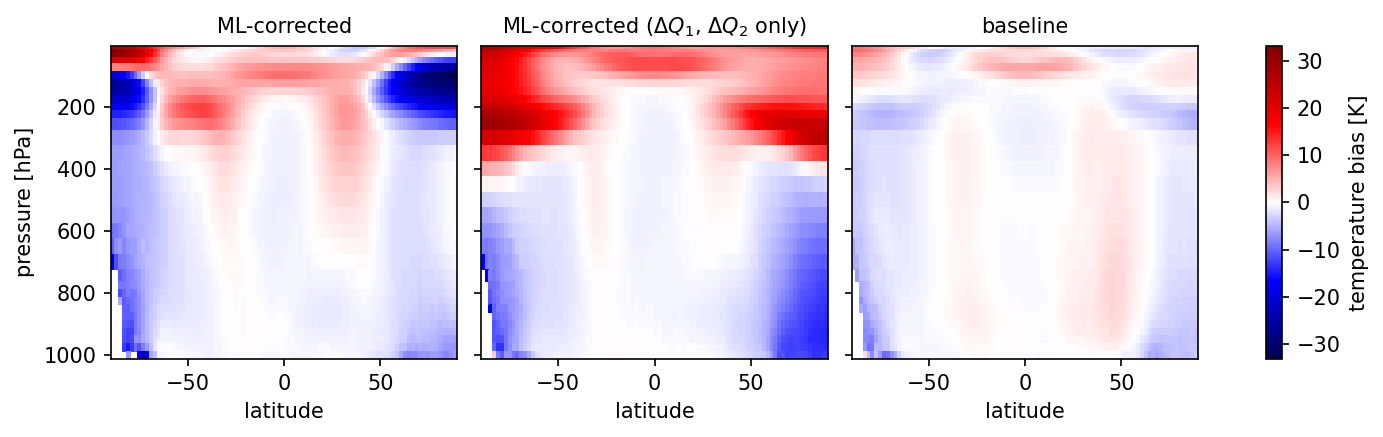

In [14]:
da = bias.temp.sel(run=list(plot_titles.values()))
fg = da.plot(y='pressure', yincrease=False, col='run', cmap='seismic')
fg.set_titles(template='{value}', maxchar=50)

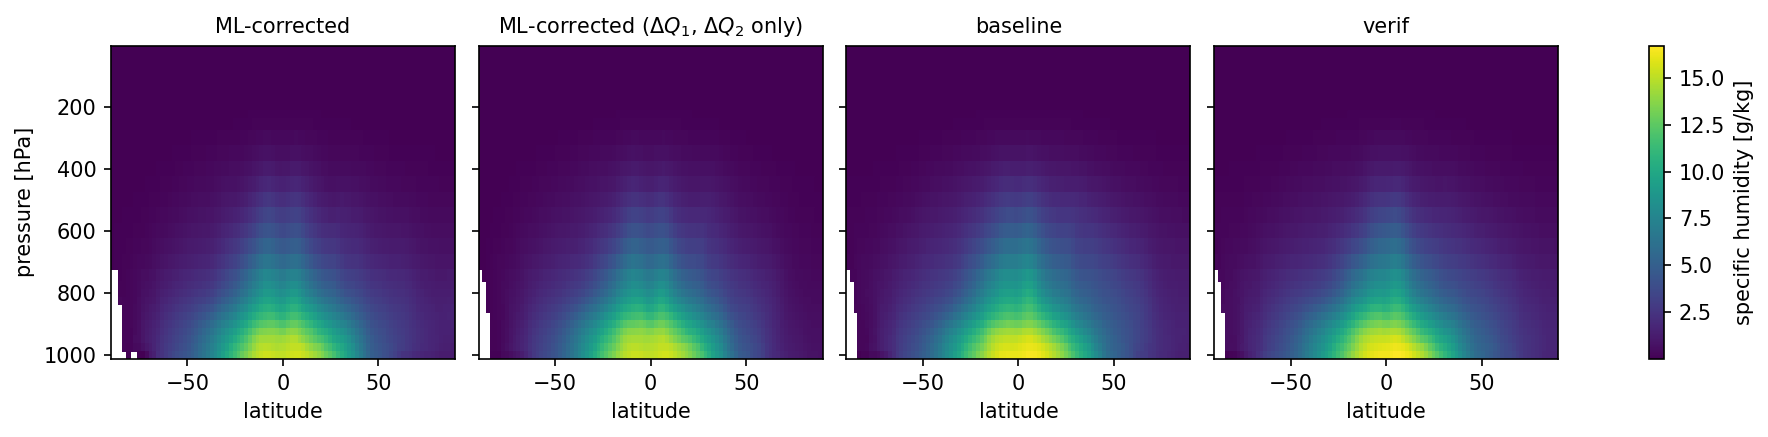

In [15]:
fg = ds_zm_clim.sphum.plot(y='pressure', yincrease=False, col='run')
fg.set_titles(template='{value}', maxchar=50)

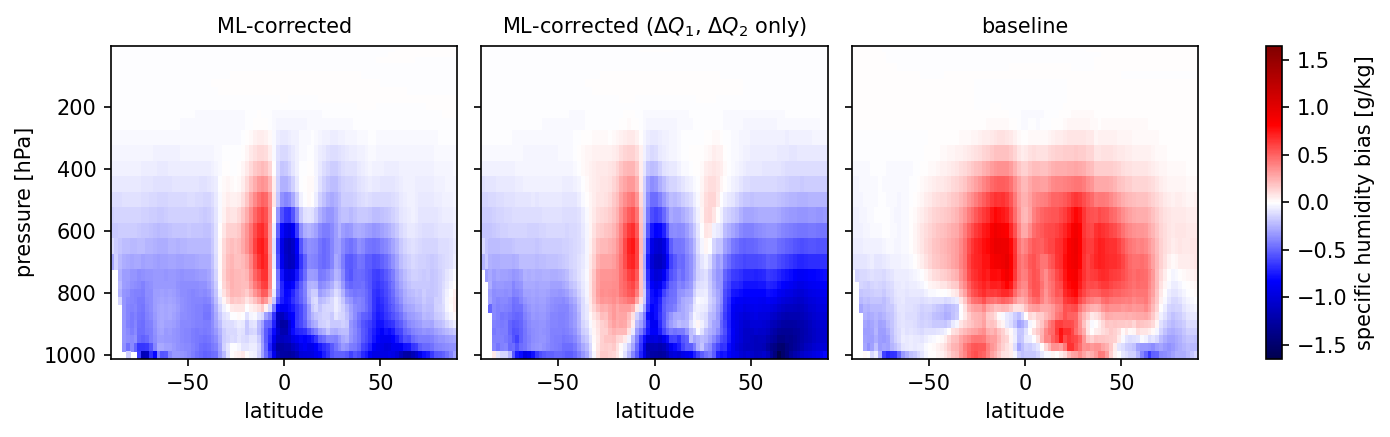

In [16]:
fg = bias.sel(run=list(plot_titles.values())).sphum.plot(y='pressure', yincrease=False, col='run', cmap='seismic')
fg.set_titles(template='{value}', maxchar=50)

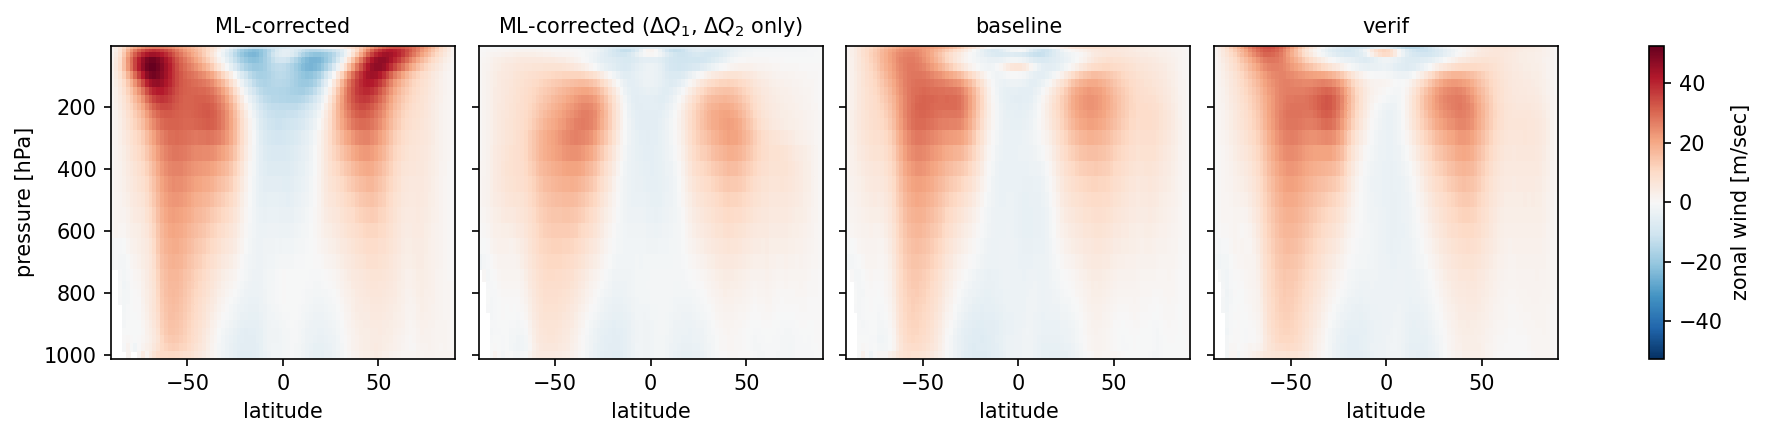

In [17]:
fg = ds_zm_clim.ucomp.plot(y='pressure', yincrease=False, col='run')
fg.set_titles(template='{value}', maxchar=50)

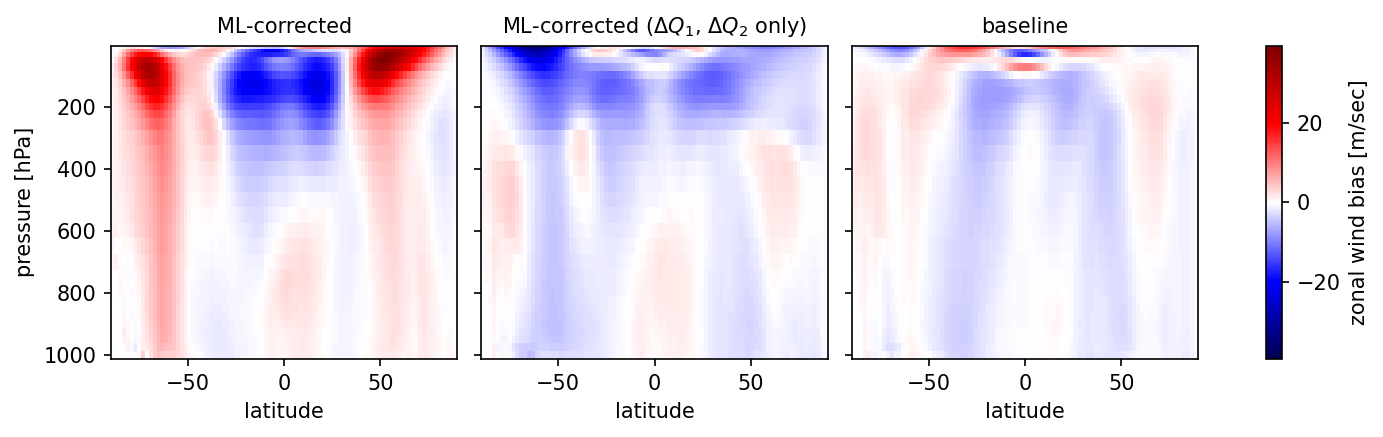

In [18]:
fg = bias.sel(run=list(plot_titles.values())).ucomp.plot(y='pressure', yincrease=False, col='run', cmap='seismic')
fg.set_titles(template='{value}', maxchar=50)

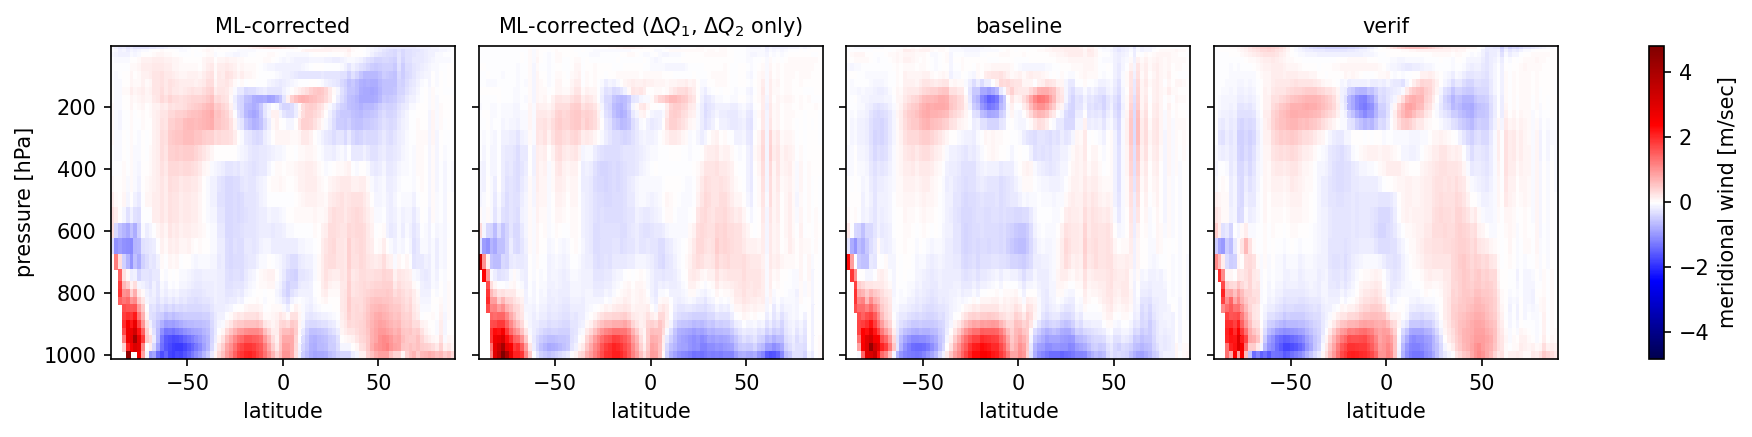

In [19]:
fg = ds_zm_clim.vcomp.plot(y='pressure', yincrease=False, col='run', cmap='seismic')
fg.set_titles(template='{value}', maxchar=50)

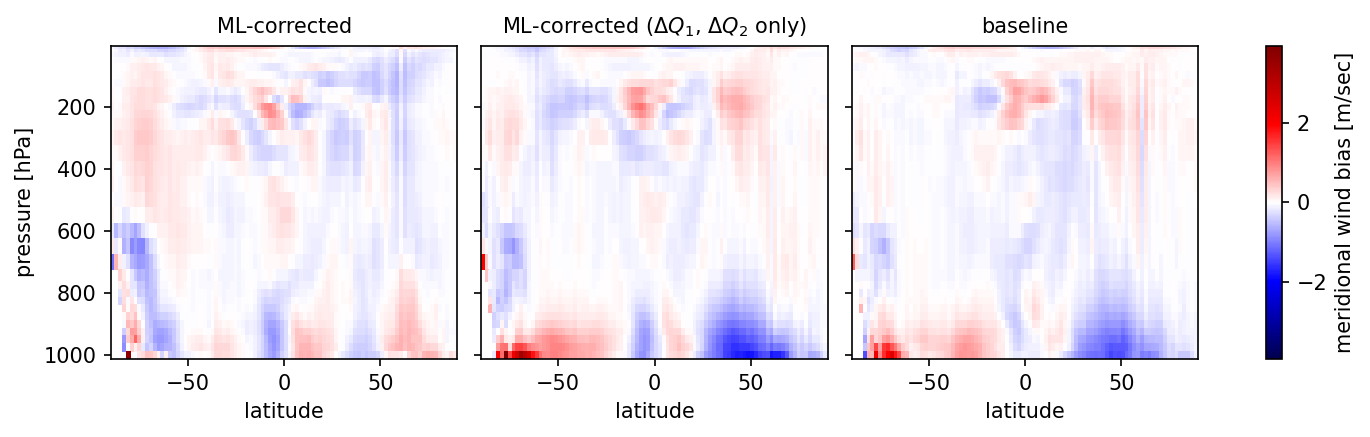

In [20]:
fg = bias.sel(run=list(plot_titles.values())).vcomp.plot(y='pressure', yincrease=False, col='run', cmap='seismic')
fg.set_titles(template='{value}', maxchar=50)